In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from cv2 import waitKey, destroyAllWindows
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights, raft_small, Raft_Small_Weights
from torchvision.utils import flow_to_image
from visualdl import LogWriter
import visualdl
device = "cuda" if torch.cuda.is_available() else "cpu"
logdir = "./log/scalar_test/train"
# 配置
image_folder = 'overDataSet4'  # 图片文件夹路径
image_test_folder = 'overDataSetTest'
# 设置输出文件夹（光流训练不动）
#output_folder = 'lightFlowOutput'  # 保存输出的光流文件夹路径
#output_PRE_folder = 'lightFlowOutputPre' # 保存输出的预测图片文件夹路径
#os.makedirs(output_folder, exist_ok=True)
#os.makedirs(output_PRE_folder, exist_ok=True)

# 加载模型
weights1= Raft_Large_Weights.C_T_SKHT_K_V2
weights2= Raft_Small_Weights.DEFAULT
model = raft_large(weights=weights1, ).to(device)

# 获取所有训练集图片文件
image_files = sorted(glob.glob(os.path.join(image_folder, '*.PNG')))
# 针对数字进行排序
image_files = sorted(image_files, key=lambda x: int((os.path.basename(x).split('.')[0]).split('_')[-1]))
num_frames = len(image_files)

# 获取所有测试集图片文件
test_image_files = sorted(glob.glob(os.path.join(image_test_folder, '*.PNG')))
# 针对数字进行排序
test_image_files = sorted(test_image_files, key=lambda x: int((os.path.basename(x).split('.')[0]).split('_')[-1]))
num_test_frames = len(test_image_files)
print(num_frames)
print(num_test_frames)

576
288


特征编码器的主要作用是从图像中提取有效的特征。由于雷达回波图像与自然图像不同，你可以重点再训练该部分，以便模型更好地捕捉雷达图像的独特模式。具体建议：

第一个卷积层：这一层接收输入图像，因此可以重新训练 convnormrelu 层，使其适应雷达图像中的颜色或纹理信息。
后续的残差块（ResidualBlock）：这些层通过不同的层次学习到越来越抽象的特征。再训练这些层，可以帮助模型更好地提取雷达回波的高层次特征。

In [2]:
# 设置要训练的层
for name, param in model.named_parameters():
    if 'convnormrelu' in name:  # 要训练的层
        param.requires_grad = True  # 只训练这一层
    else:
        param.requires_grad = False  # 冻结其他层
        
LR = 0.0001
entropy_loss = nn.L1Loss()
entropy_loss.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [3]:
# 帧预测函数
def apply_flow(image, flow):
    flow = flow.permute(0, 2, 3, 1)  # (N, H, W, 2)
    h, w = flow.shape[1:3]
    y_coords, x_coords = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    y_coords, x_coords = y_coords.float(), x_coords.float()
    y_coords, x_coords = y_coords.to(flow.device), x_coords.to(flow.device)
    # 计算新的坐标
    new_x_coords = x_coords - flow[:, :, :, 0]
    new_y_coords = y_coords - flow[:, :, :, 1]
    # 归一化坐标
    new_x_coords = (new_x_coords / (w - 1)) * 2 - 1
    new_y_coords = (new_y_coords / (h - 1)) * 2 - 1
    
    # 使用bicubic插值采样
    grid = torch.stack([new_x_coords, new_y_coords], dim=-1)
    warped_image = torch.nn.functional.grid_sample(image, grid, mode='nearest', padding_mode='reflection', align_corners=True)
    
    mean_flow_x = flow[:, :, :, 0].mean()
    mean_flow_y = flow[:, :, :, 1].mean()
    return warped_image



max_flow_step = 5.0
step = 1

# 累加光流函数
def accumulate_flow(accumulated_flow, new_flow):
    return accumulated_flow + new_flow

# 限制光流步长函数
def limit_flow_step(flow, max_step):
    return torch.clamp(flow, min=-max_step, max=max_step)  # 限制光流的最大步长



查看折线图：Terminal：visualdl --logdir ./log --port 8080

In [4]:
torch.save(model.state_dict(), 'Model/RAFTPRE.pth')
model = model.eval()

In [5]:
# 训练集生成以及帧预测
print(num_frames)
flowsToTrain = []
for i in range(num_frames - step):
#for i in range(20):
    accumulated_flow = None  # 每次更新i初始化累积光流为None
    for j in range(step):
        img1 = Image.open(image_files[i + j]).convert('RGB')
        img2 = Image.open(image_files[i + j + 1]).convert('RGB')
        
        img1_tensor = F.to_tensor(img1).unsqueeze(0)
        img2_tensor = F.to_tensor(img2).unsqueeze(0)

        # img1_tensor, img2_tensor = preprocess(img1_tensor, img2_tensor)

        with torch.no_grad():
            list_of_flows = model(img1_tensor.to(device), img2_tensor.to(device))
            predicted_flows = list_of_flows[-1].cpu()# 获取光流（一般来说最后一个最准确）
            
        # 限制光流移动步长
        # predicted_flows = limit_flow_step(predicted_flows, max_flow_step)
        
        if accumulated_flow is None:
            accumulated_flow = predicted_flows  # 如果是第一帧光流，初始化累积光流
        else:
            accumulated_flow = accumulate_flow(accumulated_flow, predicted_flows*(j/10.0))  # 叠加光流，以1/6，2/6……的方式叠加
        
        flowToTrain = accumulated_flow.squeeze()# [2, 192, 192]
        flowsToTrain.append(flowToTrain)
    

    # 不生成光流图
    # flow_imgs = flow_to_image(accumulated_flow)
    
    # 不保存光流结果
    # output_file = os.path.join(output_folder, f'accumulated_flow_{i:03d}_to_{i+step:03d}.png')
    # plt.imsave(output_file, flow_imgs.squeeze().permute(1, 2, 0).numpy())
    if i % 100 == 0:
        print(f"Processed frame {i} to {i+step}")

    
    # 不进行帧预测
    # predicted_next_frame = apply_flow(img2_tensor, accumulated_flow)
    # output_file = os.path.join(output_PRE_folder, f'predicted{i+step+1:03d}using{i:03d}to{i+step:03d}.png')
    # predicted_next_frame = predicted_next_frame.squeeze().permute(1, 2, 0).clamp(0, 1)
    # plt.imsave(output_file, predicted_next_frame.numpy())
    
print("All Trainframes processed.")
flowsToTrain = torch.stack(flowsToTrain).numpy()# [num_frames - step, 2, 192, 192]

576
Processed frame 0 to 1
Processed frame 100 to 101
Processed frame 200 to 201
Processed frame 300 to 301
Processed frame 400 to 401
Processed frame 500 to 501
All Trainframes processed.


In [6]:
# 测试集生成
flowsToTest = []
for i in range(num_test_frames - step):
    accumulated_flow = None
    for j in range(step):
        img1 = Image.open(test_image_files[i + j]).convert('RGB')
        img2 = Image.open(test_image_files[i + j + 1]).convert('RGB')
        
        img1_tensor = F.to_tensor(img1).unsqueeze(0)
        img2_tensor = F.to_tensor(img2).unsqueeze(0)
        
        # img1_tensor, img2_tensor = preprocess(img1_tensor, img2_tensor)

        with torch.no_grad():
            list_of_flows = model(img1_tensor.to(device), img2_tensor.to(device))
            predicted_flows = list_of_flows[-1].cpu()# 获取光流（一般来说最后一个最准确）
            
        # 限制光流移动步长
        # predicted_flows = limit_flow_step(predicted_flows, max_flow_step)
        
        if accumulated_flow is None:
            accumulated_flow = predicted_flows  # 如果是第一帧光流，初始化累积光流
        else:
            accumulated_flow = accumulate_flow(accumulated_flow, predicted_flows*(j/10.0))  # 叠加光流，以1/6，2/6……的方式叠加
        
        flowToTest = accumulated_flow.squeeze()# [2, 192, 192]
        flowsToTest.append(flowToTest)
        if i % 50 == 0:
            print(f"Processed frame {i} to {i+step}")
        
print("All Testframes processed.")
flowsToTest = torch.stack(flowsToTest).numpy()# [num_frames - step, 2, 192, 192]

Processed frame 0 to 1
Processed frame 50 to 51
Processed frame 100 to 101
Processed frame 150 to 151
Processed frame 200 to 201
Processed frame 250 to 251
All Testframes processed.


# 进行flow训练


In [7]:
from torch.utils.data import DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')


class FlowPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(FlowPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # 全连接层，输出维度为2（光流的两个分量）
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 全连接层
        out = self.fc(out)
        return out

Device: cuda


In [8]:
import random


def prepare_data(flows, seq_length):
    X, Y = [], []
    for i in range(len(flows) - seq_length):
        X.append(flows[i:i+seq_length])
        Y.append(flows[i+seq_length])
        
    X = np.stack(X)
    Y = np.stack(Y)
    
        # 展平每个时间步的光流数据
    X = X.reshape(X.shape[0], X.shape[1], -1)
    Y = Y.reshape(Y.shape[0], -1)
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

def create_dataloader(X, Y, batch_size):
    indices = list(range(len(X)))
    random.shuffle(indices)  # 打乱索引
    batches = [indices[i:i + batch_size] for i in range(0, len(indices), batch_size)]
    
    dataloader = []
    for batch_indices in batches:
        batch_X = X[batch_indices]
        batch_Y = Y[batch_indices]
        dataloader.append((batch_X, batch_Y))
    
    return dataloader
# 假设 flows 是一个包含多个光流序列的列表
seq_length = 5  # 每个样本的序列长度
# X:torch.Size([570, 5,192*192*2])
# Y:torch.Size([570,192*192*2])
X, Y = prepare_data(flowsToTrain, seq_length)
X_test, Y_test = prepare_data(flowsToTest, seq_length)
print(X.shape, Y.shape)
print(X_test.shape, Y_test.shape)


torch.Size([570, 5, 73728]) torch.Size([570, 73728])
torch.Size([282, 5, 73728]) torch.Size([282, 73728])


In [22]:
batch_size = 32
num_epochs = 10
model = FlowPredictor(input_dim=192*192*2, hidden_dim=256, output_dim=192 * 192 * 2, num_layers=2)
model.to(device)
criterion = nn.SmoothL1Loss()  # 均方误差损失
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
LR = 0.0001

# 创建 DataLoader
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
def train():
    model.train()
    lossnum = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossnum += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{len(dataloader)}], LossTrain: {lossnum/len(dataloader)}')

def test():
    model.eval()
    lossnum = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            lossnum += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{len(testloader)}], LossTest: {lossnum/len(testloader)}')

In [23]:

for epoch in range(num_epochs):
    dataloader = create_dataloader(X, Y, batch_size)
    testloader = create_dataloader(X_test, Y_test, batch_size)
    train()
    test()


Epoch [1/10], Step [18], LossTrain: 0.3198864112297694
Epoch [1/10], Step [9], LossTest: 0.1609292303522428
Epoch [2/10], Step [18], LossTrain: 0.2701641685432858
Epoch [2/10], Step [9], LossTest: 0.12130120313829845
Epoch [3/10], Step [18], LossTrain: 0.18870023058520424
Epoch [3/10], Step [9], LossTest: 0.10971174803045061
Epoch [4/10], Step [18], LossTrain: 0.1435209827290641
Epoch [4/10], Step [9], LossTest: 0.09487975968254937
Epoch [5/10], Step [18], LossTrain: 0.12128310029705365
Epoch [5/10], Step [9], LossTest: 0.09027901457415687
Epoch [6/10], Step [18], LossTrain: 0.10744948788649505
Epoch [6/10], Step [9], LossTest: 0.09452992843257056
Epoch [7/10], Step [18], LossTrain: 0.09792098568545447
Epoch [7/10], Step [9], LossTest: 0.09184961683220333
Epoch [8/10], Step [18], LossTrain: 0.09253708293868436
Epoch [8/10], Step [9], LossTest: 0.09337342944410112
Epoch [9/10], Step [18], LossTrain: 0.09040544844335979
Epoch [9/10], Step [9], LossTest: 0.09032640647557047
Epoch [10/10],

In [24]:
torch.save(model.state_dict(), 'Model/flowPre.pth')
model = model.eval()

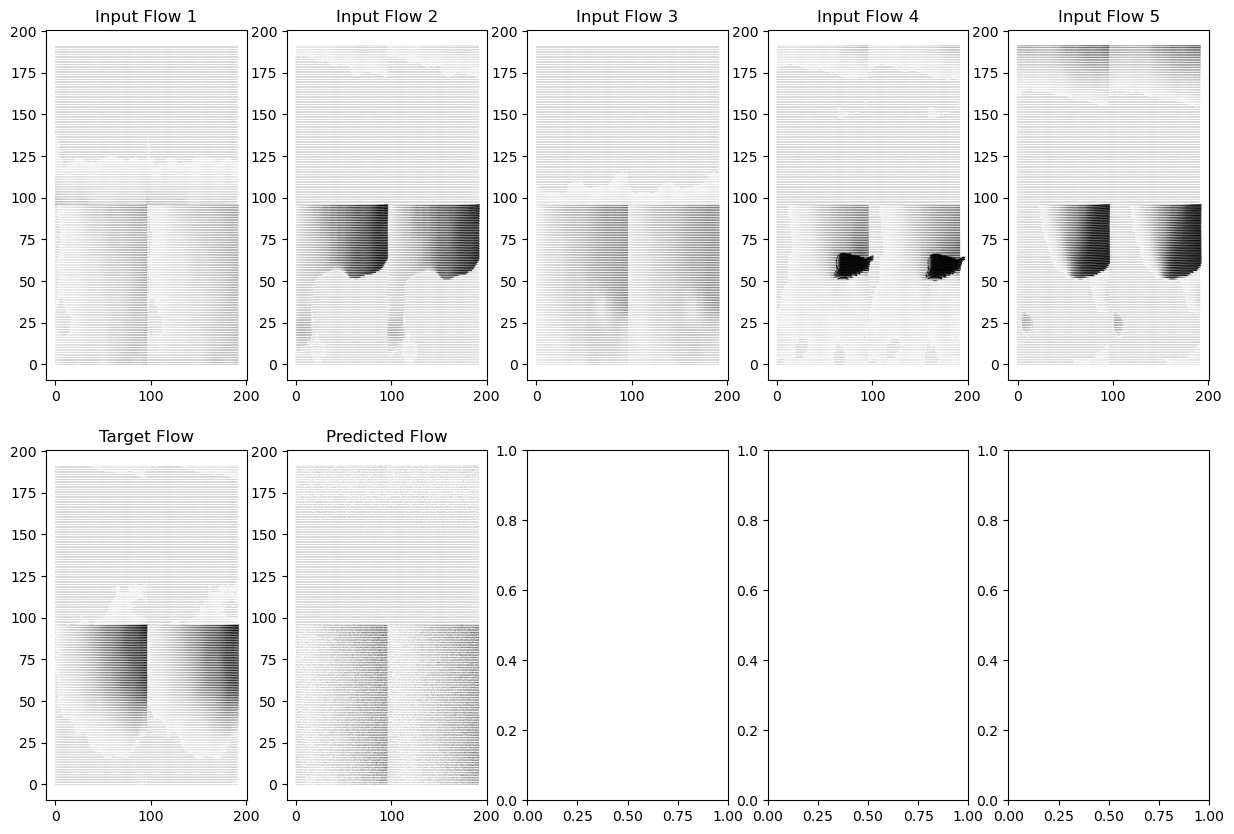

In [26]:
model.load_state_dict(torch.load('Model/flowPre.pth',weights_only=False))
model.eval()

def visualize_flow_sequence(inputs, target, prediction, height, width):
    inputs = inputs.cpu().numpy().reshape(-1, height, width, 2)
    target = target.cpu().numpy().reshape(height, width, 2)
    prediction = prediction.cpu().numpy().reshape(height, width, 2)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    
    for i in range(5):
        ax = axes[0, i % 5]
        ax.quiver(inputs[i, :, :, 0], inputs[i, :, :, 1])
        ax.set_title(f'Input Flow {i+1}')
    
    axes[1, 0].quiver(target[:, :, 0], target[:, :, 1])
    axes[1, 0].set_title('Target Flow')
    
    axes[1, 1].quiver(prediction[:, :, 0], prediction[:, :, 1])
    axes[1, 1].set_title('Predicted Flow')
    
    plt.show()
    
    
# 选择一个测试样本
with torch.no_grad():
    inputs, targets = next(iter(create_dataloader(X_test, Y_test, batch_size)))
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # 前向传播
    predictions = model(inputs)
    
    # 选择第一个样本进行可视化
    input_sample = inputs[0]
    target_sample = targets[0]
    prediction_sample = predictions[0]
    
    visualize_flow_sequence(input_sample, target_sample, prediction_sample, 192, 192)